# A Galaxy Lacking Dark Matter (?)

The code in this notebook reproduces an estimate for the velocity dispersion of the ultra-diffuse galaxy NGC1052–DF2 presented in a paper by [van Dokkum et al. (2018)](https://arxiv.org/abs/1803.10237), and checks that result using a different technique (as [suggested by N. Martin](https://twitter.com/nfmartin1980/status/982245161735372804) and others).

In [ ]:
from astropy.stats import biweight_scale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
from scipy.interpolate import interp1d
from scipy.stats import percentileofscore
import theano as thno
import theano.tensor as T

In [2]:
# see Fig. 5 in the paper
df = pd.read_csv("data.csv")

In [3]:
df

,id,v,v_err
0,GC-39,14.728960,7.046859
1,GC-59,-3.892651,15.641404
2,GC-71,2.048405,6.883926
3,GC-73,10.576495,3.258663
4,GC-77,1.171631,5.906327
5,GC-85,-1.907788,5.376794
6,GC-91,-1.212140,9.694343
7,GC-92,-14.320283,6.761636
8,GC-98,-39.335900,12.586586
9,GC-101,-3.375351,13.523452


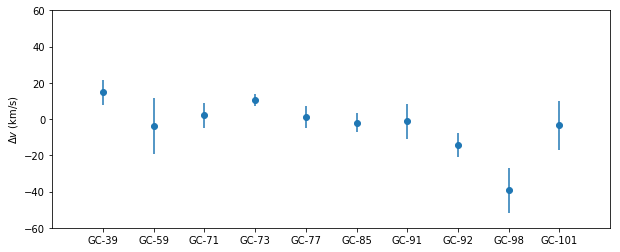

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(df.index, df["v"], yerr=df["v_err"], marker="o", linestyle="none")
ax.set_xticks(df.index)
ax.set_xticklabels(df["id"])
ax.set_xlim([-1, 10])
ax.set_ylim([-60, 60])
ax.set_ylabel(r"$\Delta v$ (km/s)")
plt.show()

In [5]:
# store data as theano variables
v_meas = thno.shared(np.asarray(df["v"], dtype=thno.config.floatX), name="v_meas")
v_meas_err = thno.shared(np.asarray(df["v_err"], dtype=thno.config.floatX), name="v_meas_err")

## Method 1

In [6]:
sigma_obs = biweight_scale(df["v"])

In [8]:
print(f"sigma_obs = {sigma_obs:.2f} km/s")

sigma_obs = 8.54 km/s


In [9]:
def estimate_sigma(sigma_test, n_sample=5000):
    sigma_test_obs = np.empty(n_sample)
    
    for n in range(n_sample):
        v_tracer = np.random.normal(0, sigma_test, size=len(df))
    
        for i, v_err in enumerate(df["v_err"]):
            v_tracer[i] += np.random.normal(0, v_err)
        
        sigma_test_obs[n] = biweight_scale(v_tracer)
        
    return sigma_test_obs

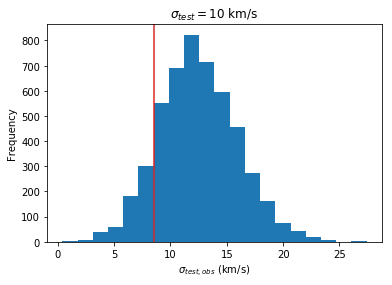

In [10]:
fig, ax = plt.subplots()
ax.hist(estimate_sigma(sigma_test=10), bins=20)
ax.axvline(sigma_obs, color="C3")
ax.set_xlabel(r"$\sigma_{test,obs}$ (km/s)")
ax.set_ylabel(r"Frequency")
ax.set_title(r"$\sigma_{test}=10$ km/s")
plt.show()

In [11]:
def get_percentile(sigma_test, sigma_obs):
    sigma_test_obs = estimate_sigma(sigma_test)
    return percentileofscore(sigma_test_obs, sigma_obs)  

sigma_test = np.linspace(1, 20, 50)
p_sigma_test = np.array([get_percentile(sigma, sigma_obs) for sigma in sigma_test])

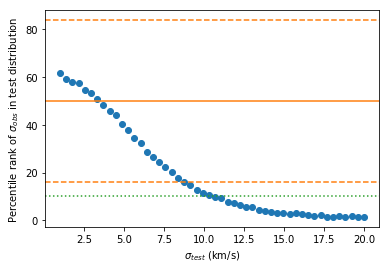

In [12]:
fig, ax = plt.subplots()
ax.scatter(sigma_test, p_sigma_test)
ax.axhline(50, color="C1")
ax.axhline(16, color="C1", linestyle="--")
ax.axhline(84, color="C1", linestyle="--")
ax.axhline(10, color="C2", linestyle=":")
ax.set_xlabel(r"$\sigma_{test}$ (km/s)")
ax.set_ylabel(r"Percentile rank of $\sigma_{obs}$ in test distribution")
plt.show()

In [13]:
f_inv = interp1d(p_sigma_test, sigma_test)
print(f"sigma < {f_inv(10):.2f} km/s at 90% confidence")

sigma < 10.60 km/s at 90% confidence


## Method 2

In [ ]:
with pm.Model() as model:
    mean = pm.Uniform("mean", -50, 50)
    log_sigma = pm.Uniform("log_sigma", np.log(0.1), np.log(50))
    
    v_tracer = pm.Normal("v_tracer", mu=mean, sd=v_meas_err, shape=len(df))
    
    v_obs = pm.Normal("v_obs", mu=v_tracer, sd=T.exp(log_sigma), observed=v_meas)
    
    trace = pm.sample(50000, tune=5000, cores=32)

    with open("trace_2.pkl", "wb") as pickle_file:
        pickle.dump({"model": model, "trace": trace}, pickle_file)

In [6]:
with open("trace_2.pkl", "rb") as pickle_file:
    pickle_data = pickle.load(pickle_file)
    model, trace = pickle_data["model"], pickle_data["trace"]

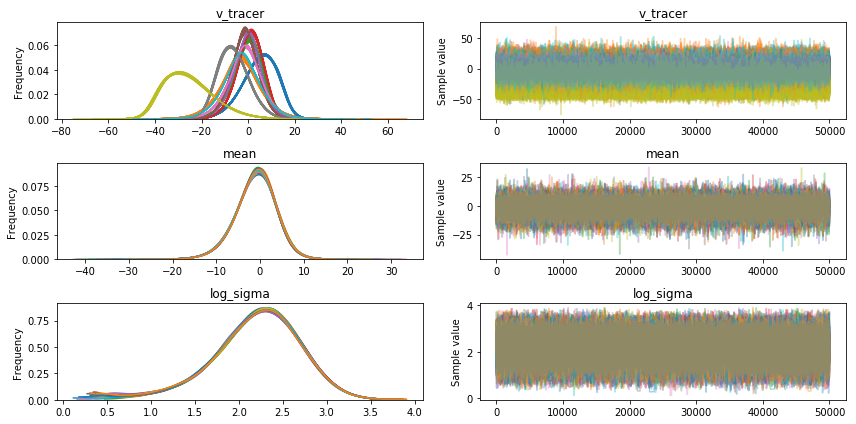

In [7]:
pm.traceplot(trace)
plt.show()

In [8]:
sigma = np.exp(trace["log_sigma"])

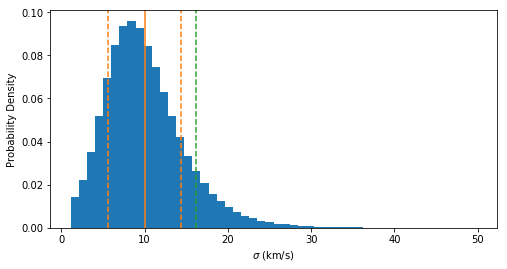

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(sigma, bins=50, density=True)
ax.axvline(np.mean(sigma), color="C1")
ax.axvline(np.percentile(sigma, 16), color="C1", linestyle="--")
ax.axvline(np.percentile(sigma, 84), color="C1", linestyle="--")
ax.axvline(np.percentile(sigma, 90), color="C2", linestyle="--")
ax.set_xlabel(r"$\sigma$ (km/s)")
ax.set_ylabel("Probability Density")
plt.show()

In [10]:
print(f"sigma < {np.percentile(sigma, 90):.2f} km/s at 90% confidence")

sigma < 16.24 km/s at 90% confidence


In [11]:
print(f"sigma < 10 km/s at {percentileofscore(sigma, 10):.0f}% confidence")

sigma < 10 km/s at 55% confidence


In [ ]:
# when excluding the most extreme measurement (GC-98):
# sigma < 10.86 km/s at 90% confidence
# sigma < 10 km/s at 86% confidence

## Method 3

In [7]:
# https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html

In [12]:
def log_likelihood(v_meas, is_outlier, v_tracer, sigma, mean_outlier, sigma_outlier):    
    value = 0
    
    pdf = T.exp(-(v_meas - v_tracer)**2 / (2*sigma**2))
    pdf /= T.sqrt(2*np.pi * sigma**2)
    value += T.sum(T.log(pdf) * (1 - is_outlier))

    pdf = T.exp(-(v_meas - mean_outlier)**2 / (2*(sigma**2 + sigma_outlier**2)))
    pdf /= T.sqrt(2*np.pi * (sigma**2 + sigma_outlier**2))
    value += T.sum(T.log(pdf) * is_outlier)

    return value

In [ ]:
with pm.Model() as model:
    mean = pm.Uniform("mean", -50, 50)
    log_sigma = pm.Uniform("log_sigma", np.log(0.1), np.log(50))
    
    v_tracer = pm.Normal("v_tracer", mu=mean, sd=v_meas_err, shape=len(df))
    
    mean_outlier = pm.Uniform("mean_outlier", -100, 100)
    log_sigma_outlier = pm.Uniform("log_sigma_outlier", np.log(0.1), np.log(500))
    
    frac_outlier = pm.Uniform("frac_outlier", 0, 0.5)
    is_outlier = pm.Bernoulli("is_outlier", p=frac_outlier, shape=len(df))
    
    v_obs = pm.DensityDist("v_obs", log_likelihood,
                           observed={
                               "v_meas": v_meas,
                               "is_outlier": is_outlier,
                               "v_tracer": v_tracer,
                               "sigma": T.exp(log_sigma),
                               "mean_outlier": mean_outlier,
                               "sigma_outlier": T.exp(log_sigma_outlier)})
    
    step1 = pm.Metropolis([frac_outlier, mean_outlier, log_sigma_outlier,
                           v_tracer, mean, log_sigma])
    step2 = pm.step_methods.BinaryGibbsMetropolis([is_outlier])
    trace = pm.sample(50000, tune=5000, step=[step1, step2], cores=32)

    with open("trace_3.pkl", "wb") as pickle_file:
        pickle.dump({"model": model, "trace": trace}, pickle_file)

In [13]:
with open("trace_3.pkl", "rb") as pickle_file:
    pickle_data = pickle.load(pickle_file)
    model, trace = pickle_data["model"], pickle_data["trace"]

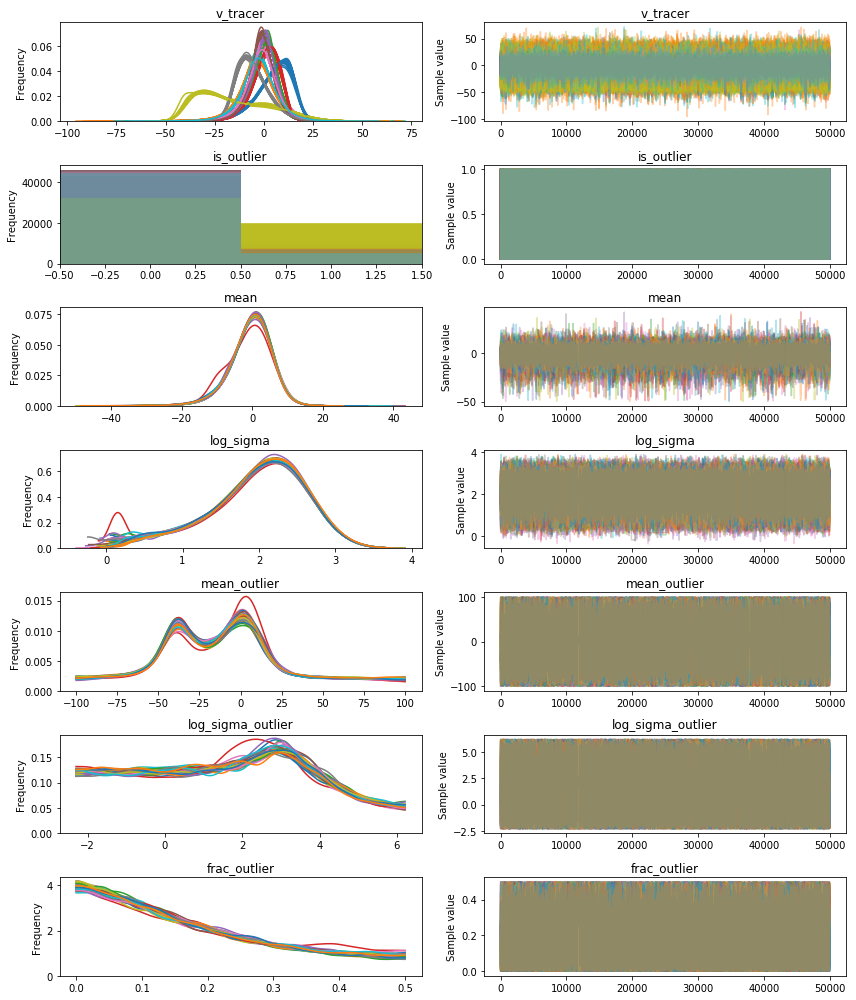

In [14]:
pm.traceplot(trace)
plt.show()

In [15]:
sigma = np.exp(trace["log_sigma"])
p_outlier = np.mean(trace["is_outlier"], axis=0)

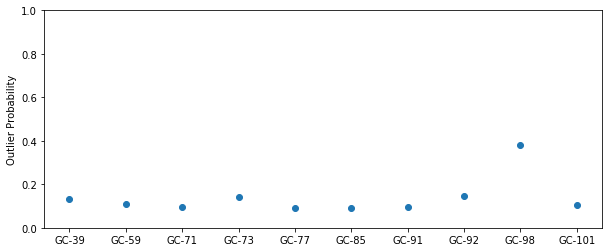

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(df["id"], p_outlier)
ax.set_ylim(0, 1)
ax.set_ylabel("Outlier Probability")
plt.show()

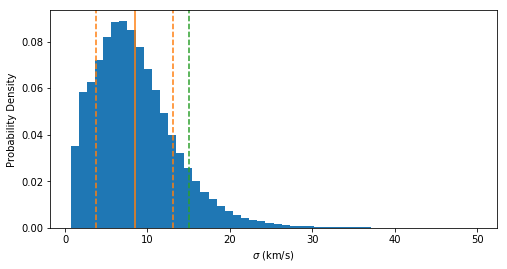

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(sigma, bins=50, density=True)
ax.axvline(np.mean(sigma), color="C1")
ax.axvline(np.percentile(sigma, 16), color="C1", linestyle="--")
ax.axvline(np.percentile(sigma, 84), color="C1", linestyle="--")
ax.axvline(np.percentile(sigma, 90), color="C2", linestyle="--")
ax.set_xlabel(r"$\sigma$ (km/s)")
ax.set_ylabel("Probability Density")
plt.show()

In [18]:
print(f"sigma < {np.percentile(sigma, 90):.2f} km/s at 90% confidence")

sigma < 15.00 km/s at 90% confidence


In [19]:
print(f"sigma < 10 km/s at {percentileofscore(sigma, 10):.0f}% confidence")

sigma < 10 km/s at 67% confidence
